# Maps of the transmission network

This notebook contains various maps of the transmission network, created using [PyGMT](https://www.pygmt.org/), a Python interface for the [Generic Mapping Tools](https://www.generic-mapping-tools.org/).

In [1]:
import pygmt

Import the model file of continental Europe:

In [2]:
import json

with open('../europe.json') as f:
    model = json.load(f)

## Base map

The region to be mapped is defined in terms of latitude (from 34°N to 59° N) and longitude (from 12° W to 31° E):

In [3]:
region = [-12, 31, 34, 59]

Countries that are part of the model are shaded in gray (including Kosovo, which is not separated from Serbia in PanTaGruEl, as well as Andorra and San Marino that do not have any high-voltage buses):

In [4]:
countries = {bus['country'] for bus in model['bus'].values()}.union({'XK', 'AD', 'SM'}) - {'XX'}

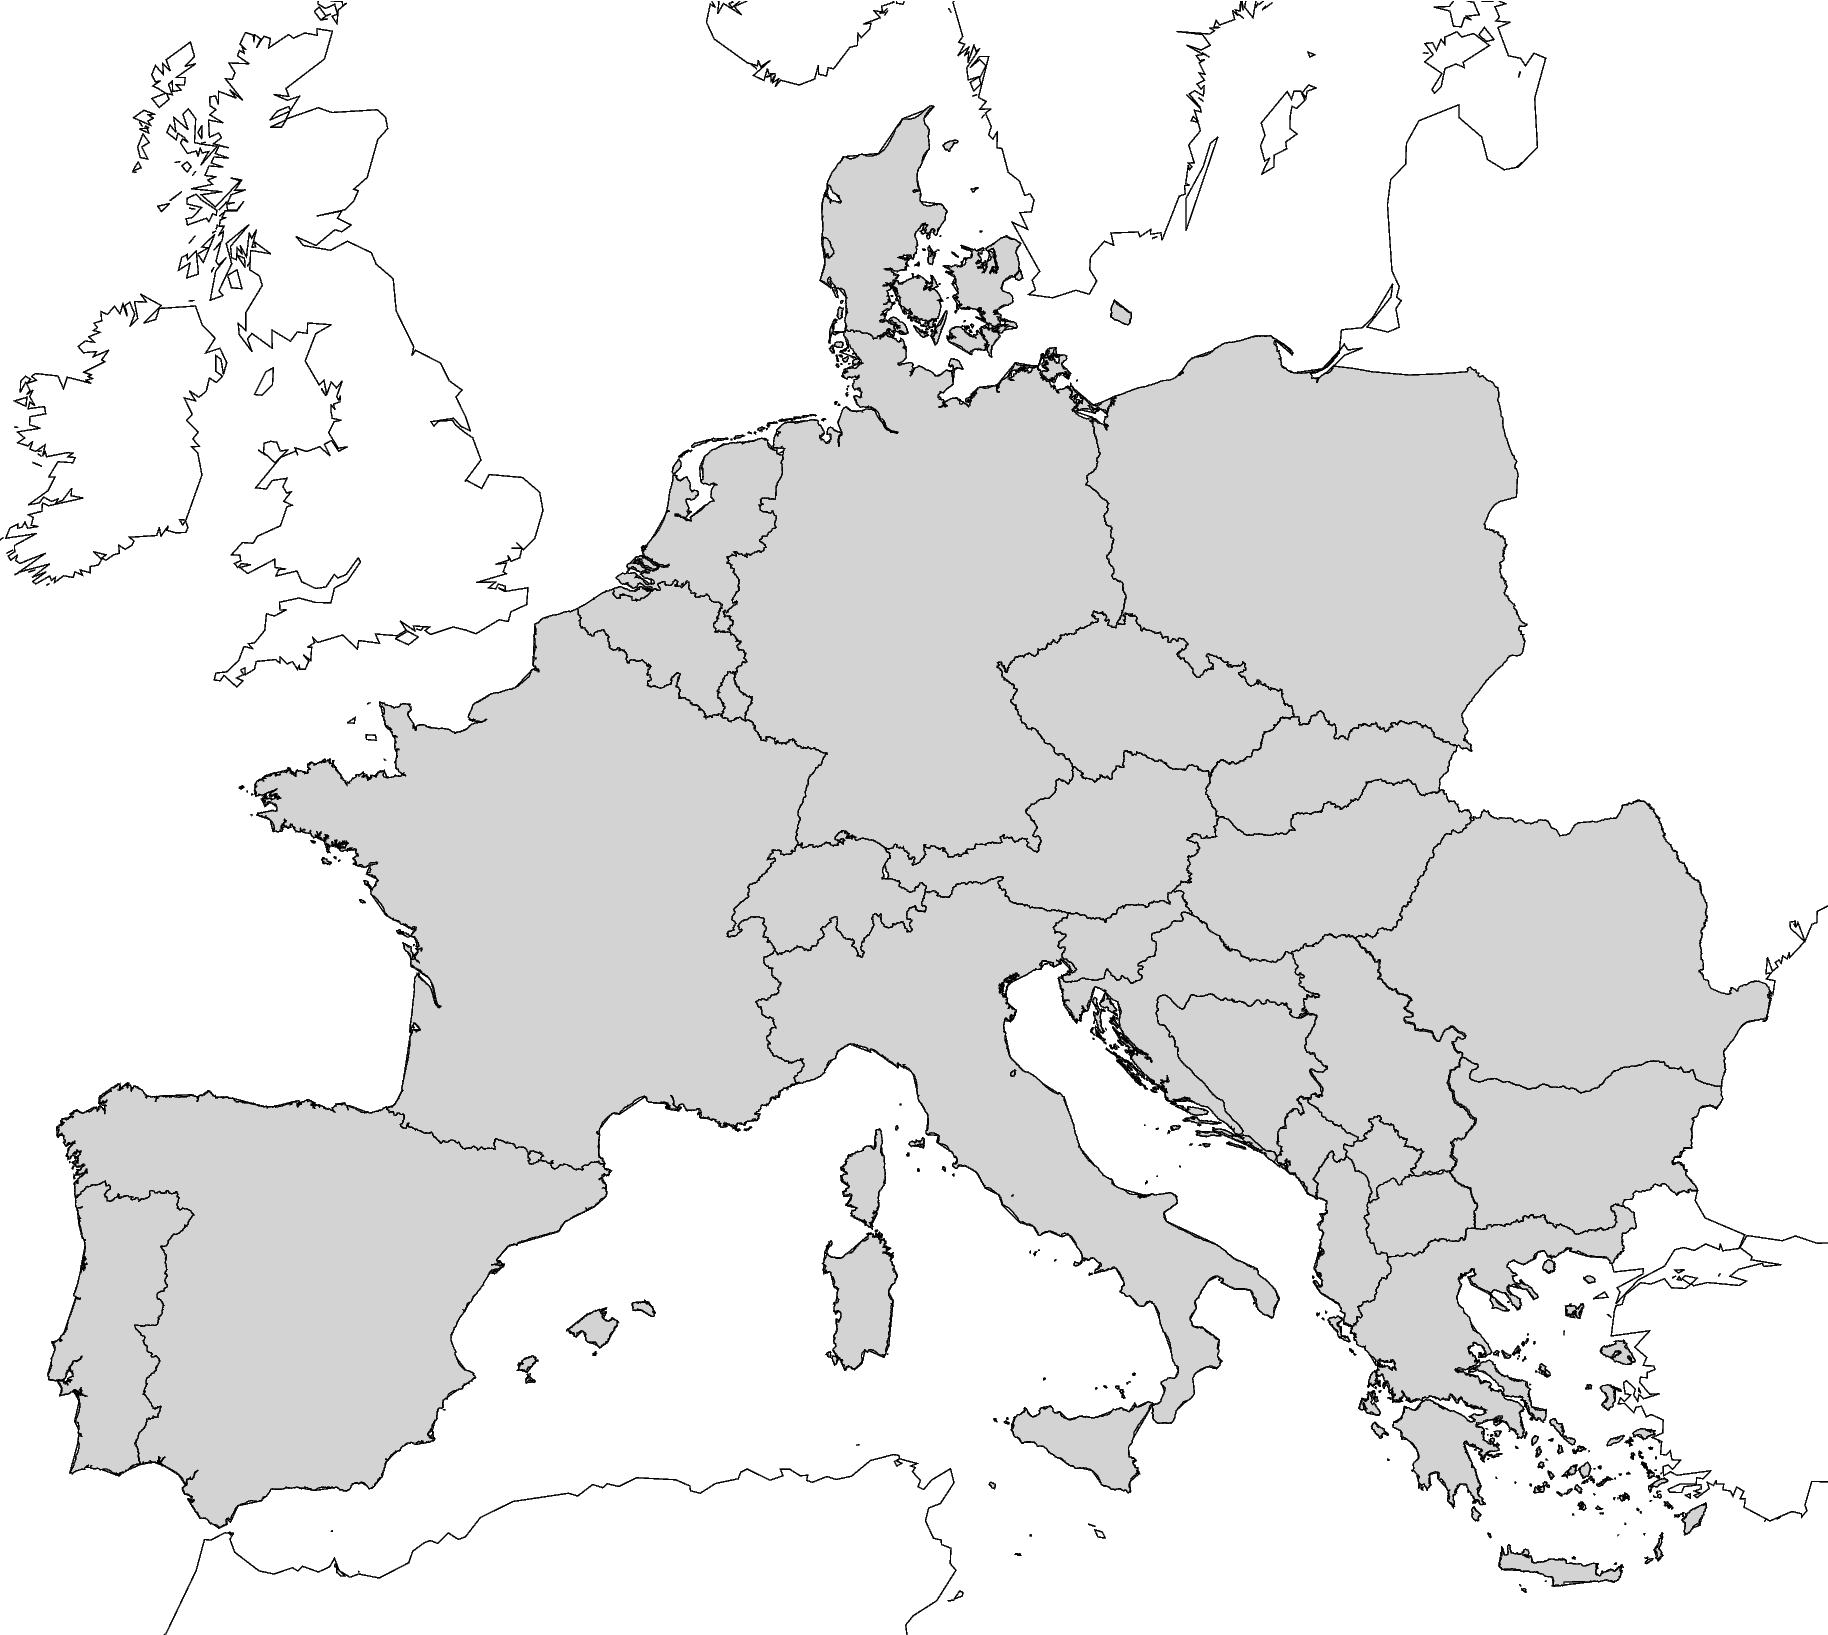

In [5]:
fig = pygmt.Figure()

fig.coast(region=region, projection='M16c', resolution='l',
          shorelines='1/0.2p,black', # coast only, no lakes
          dcw=['%s+p0.2p,black+glightgray' % country for country in countries]) # country borders 

fig.show()

## Buses

Map of all the buses in the model:

In [6]:
all_buses = [bus['coord'] for bus in model['bus'].values()]

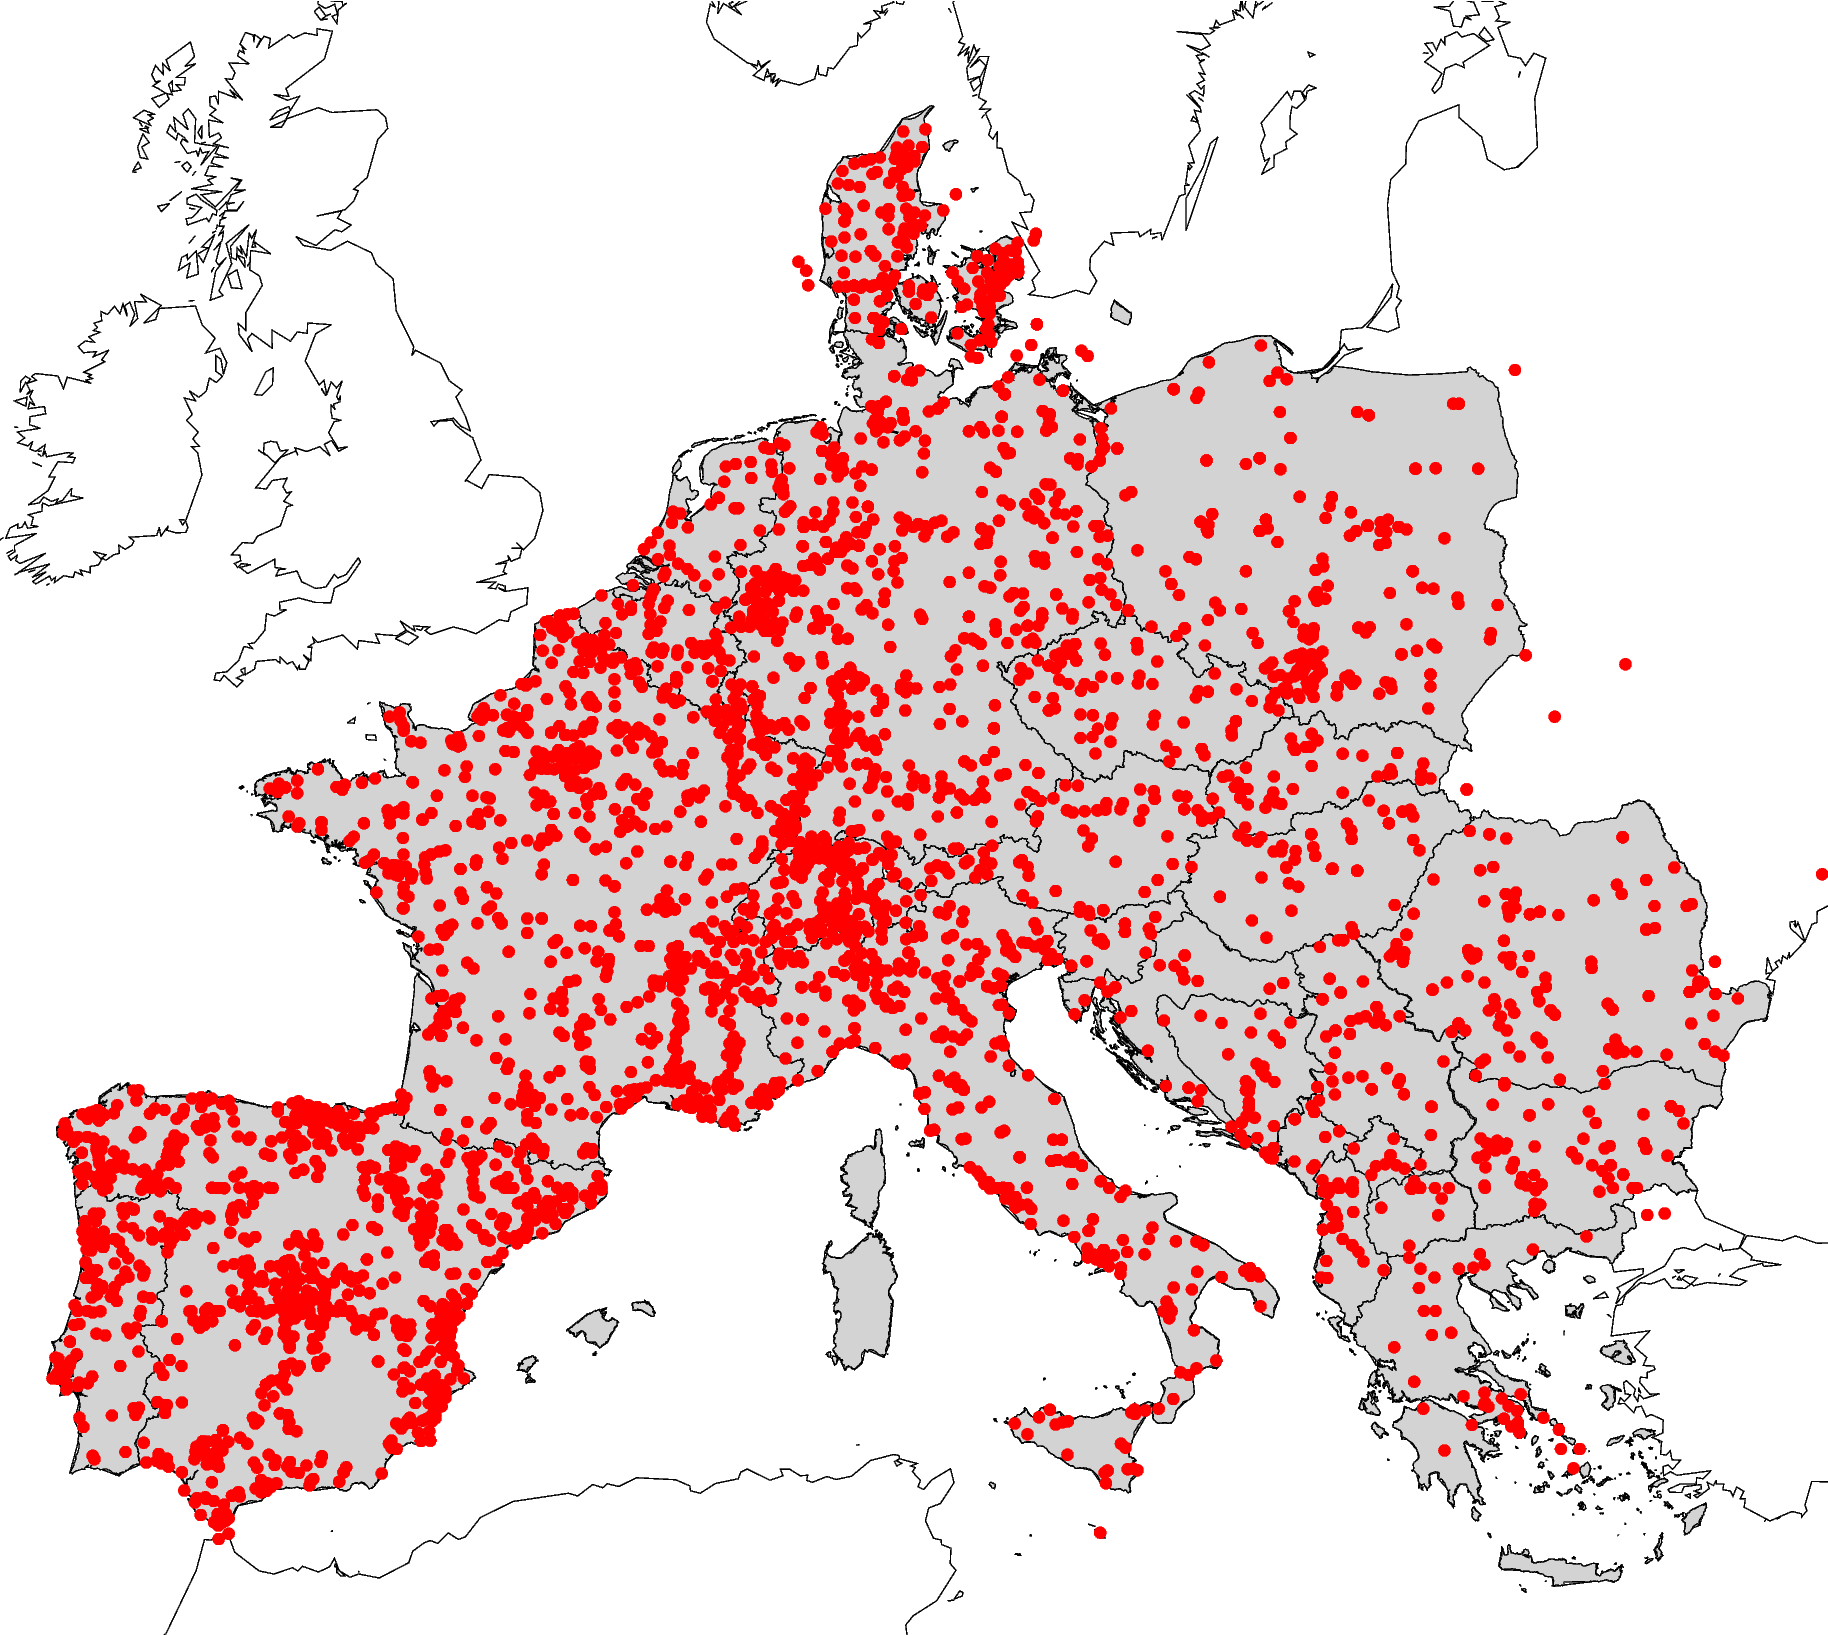

In [7]:
fig = pygmt.Figure()

fig.coast(region=region, projection='M16c', resolution='l',
          shorelines='1/0.2p,black', # coast only, no lakes
          dcw=['%s+p0.2p,black+glightgray' % country for country in countries]) # country borders

fig.plot(data = all_buses, style='c0.1c', fill='red')

fig.show()

## Lines

Map of all the lines in the model:

In [8]:
lines = [(model['bus'][str(line['f_bus'])]['coord'], model['bus'][str(line['t_bus'])]['coord'])
         for line in model['branch'].values() if line['transformer'] == False]

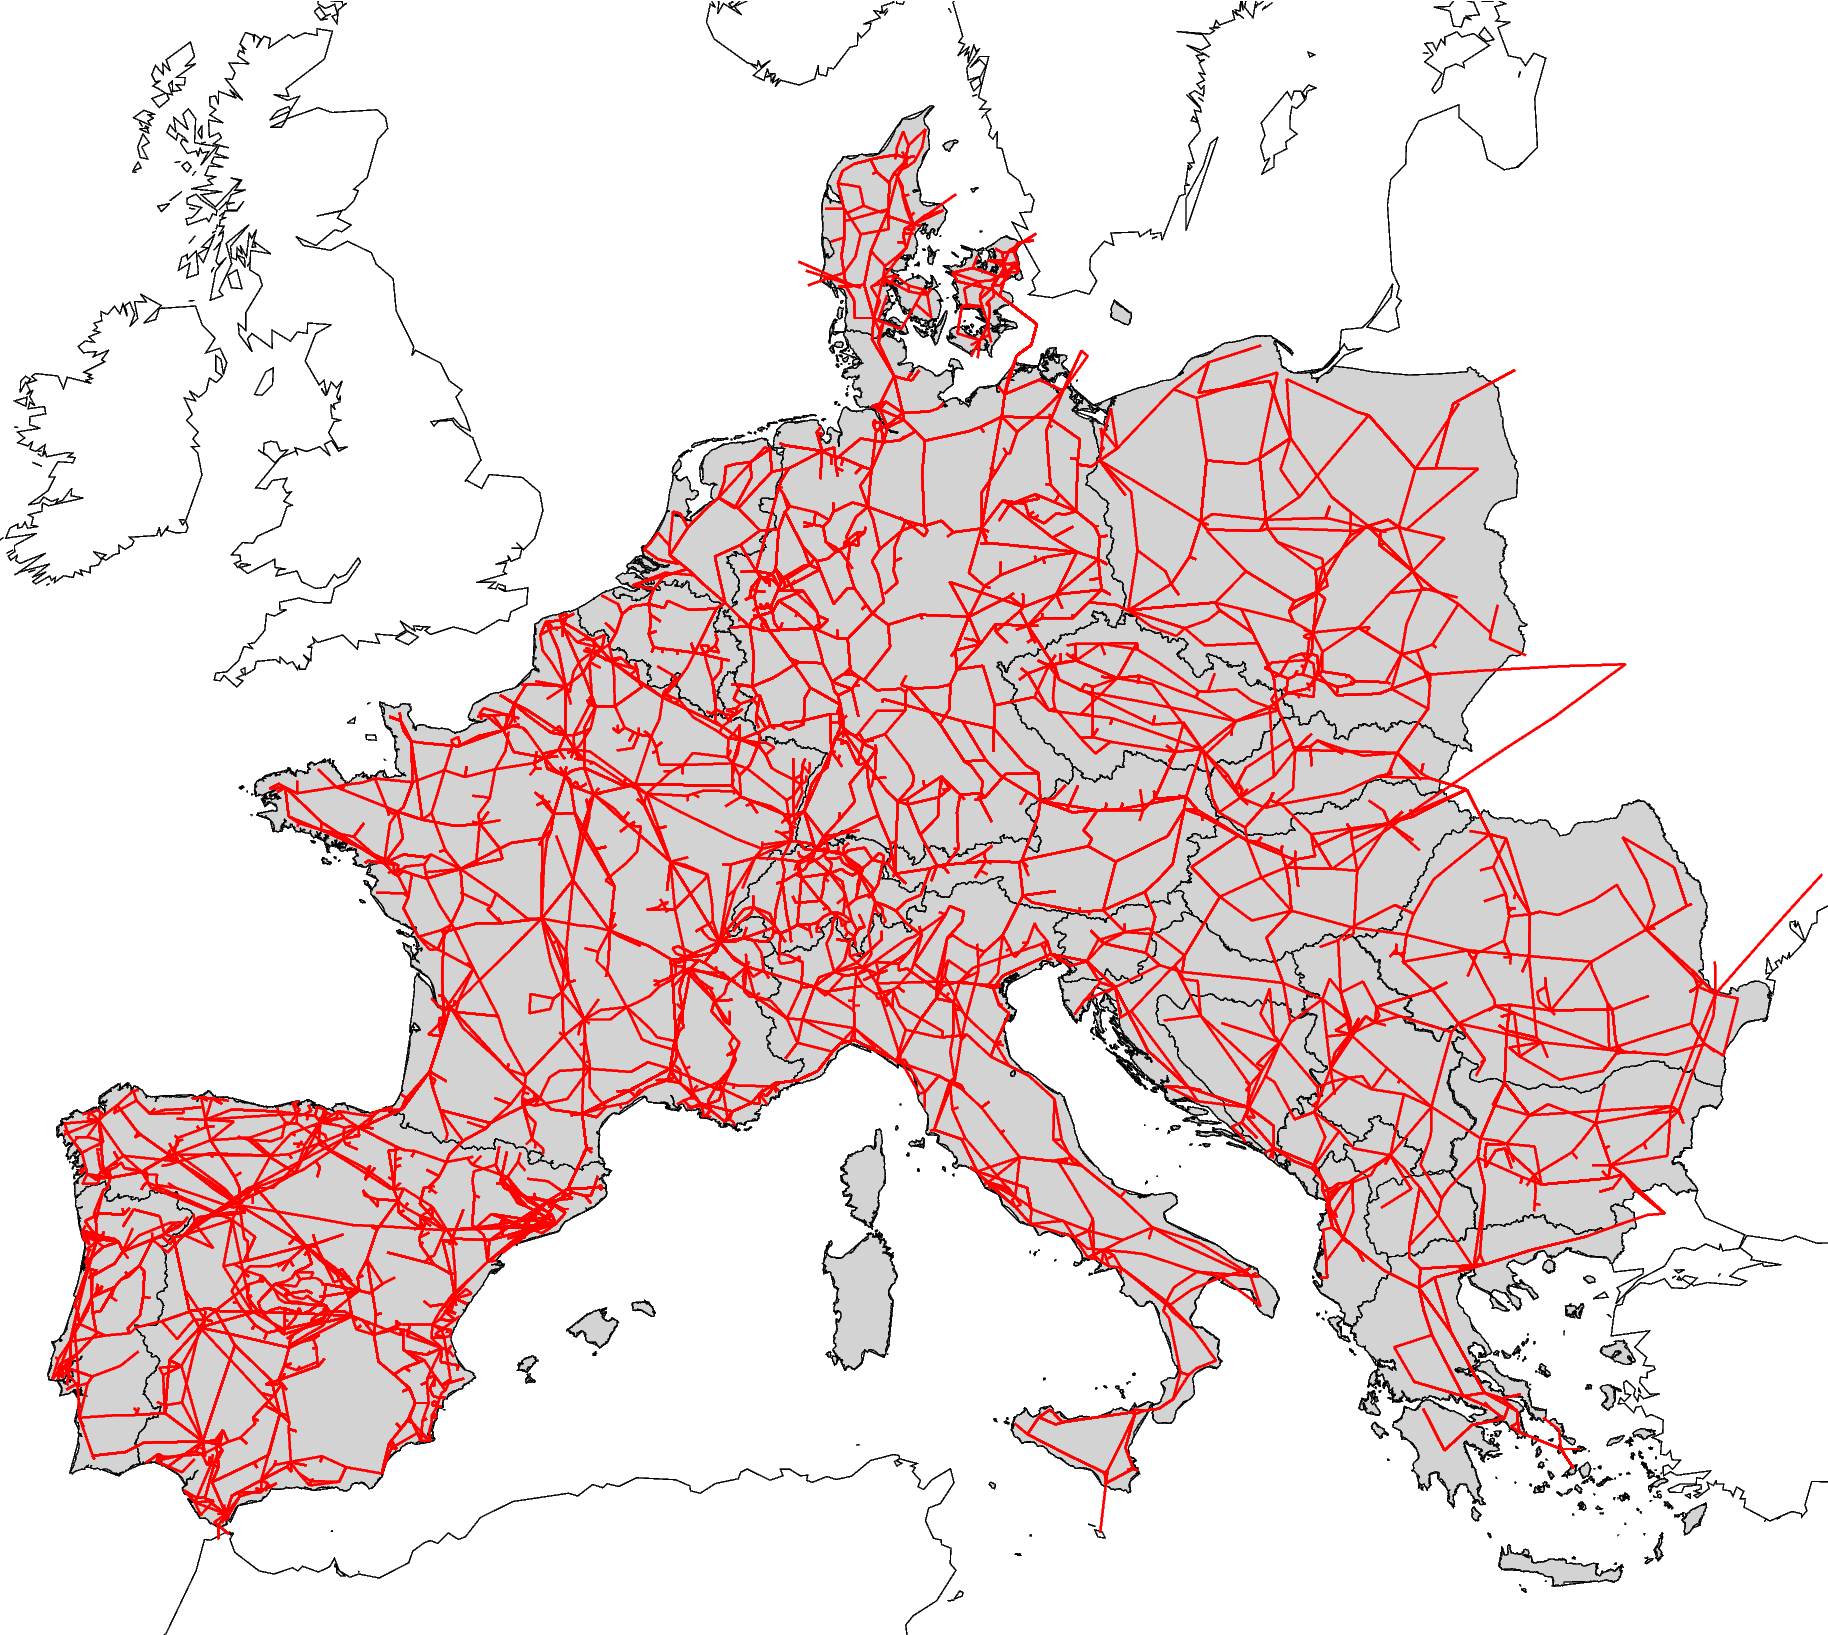

In [9]:
fig = pygmt.Figure()

fig.coast(region=region, projection='M16c', resolution='l',
          shorelines='1/0.2p,black', # coast only, no lakes
          dcw=['%s+p0.2p,black+glightgray' % country for country in countries]) # country borders

for line in lines:
    fig.plot(x = [line[0][0], line[1][0]], y = [line[0][1], line[1][1]], pen='0.5p,red')

fig.show()

### Lines colored by voltage

There are four distinct voltage levels in the model:

In [10]:
voltage_levels = {bus['base_kv'] for bus in model['bus'].values()}
voltage_levels

{132, 220, 380, 750}

We assign one color to each voltage level:

In [11]:
voltage_color = {
    132: 'blue',
    220: 'darkgreen',
    380: 'red',
    750: 'orange'
}

In [12]:
lines = [(model['bus'][str(line['f_bus'])]['coord'], model['bus'][str(line['t_bus'])]['coord'], model['bus'][str(line['f_bus'])]['base_kv'])
         for line in model['branch'].values() if line['transformer'] == False]

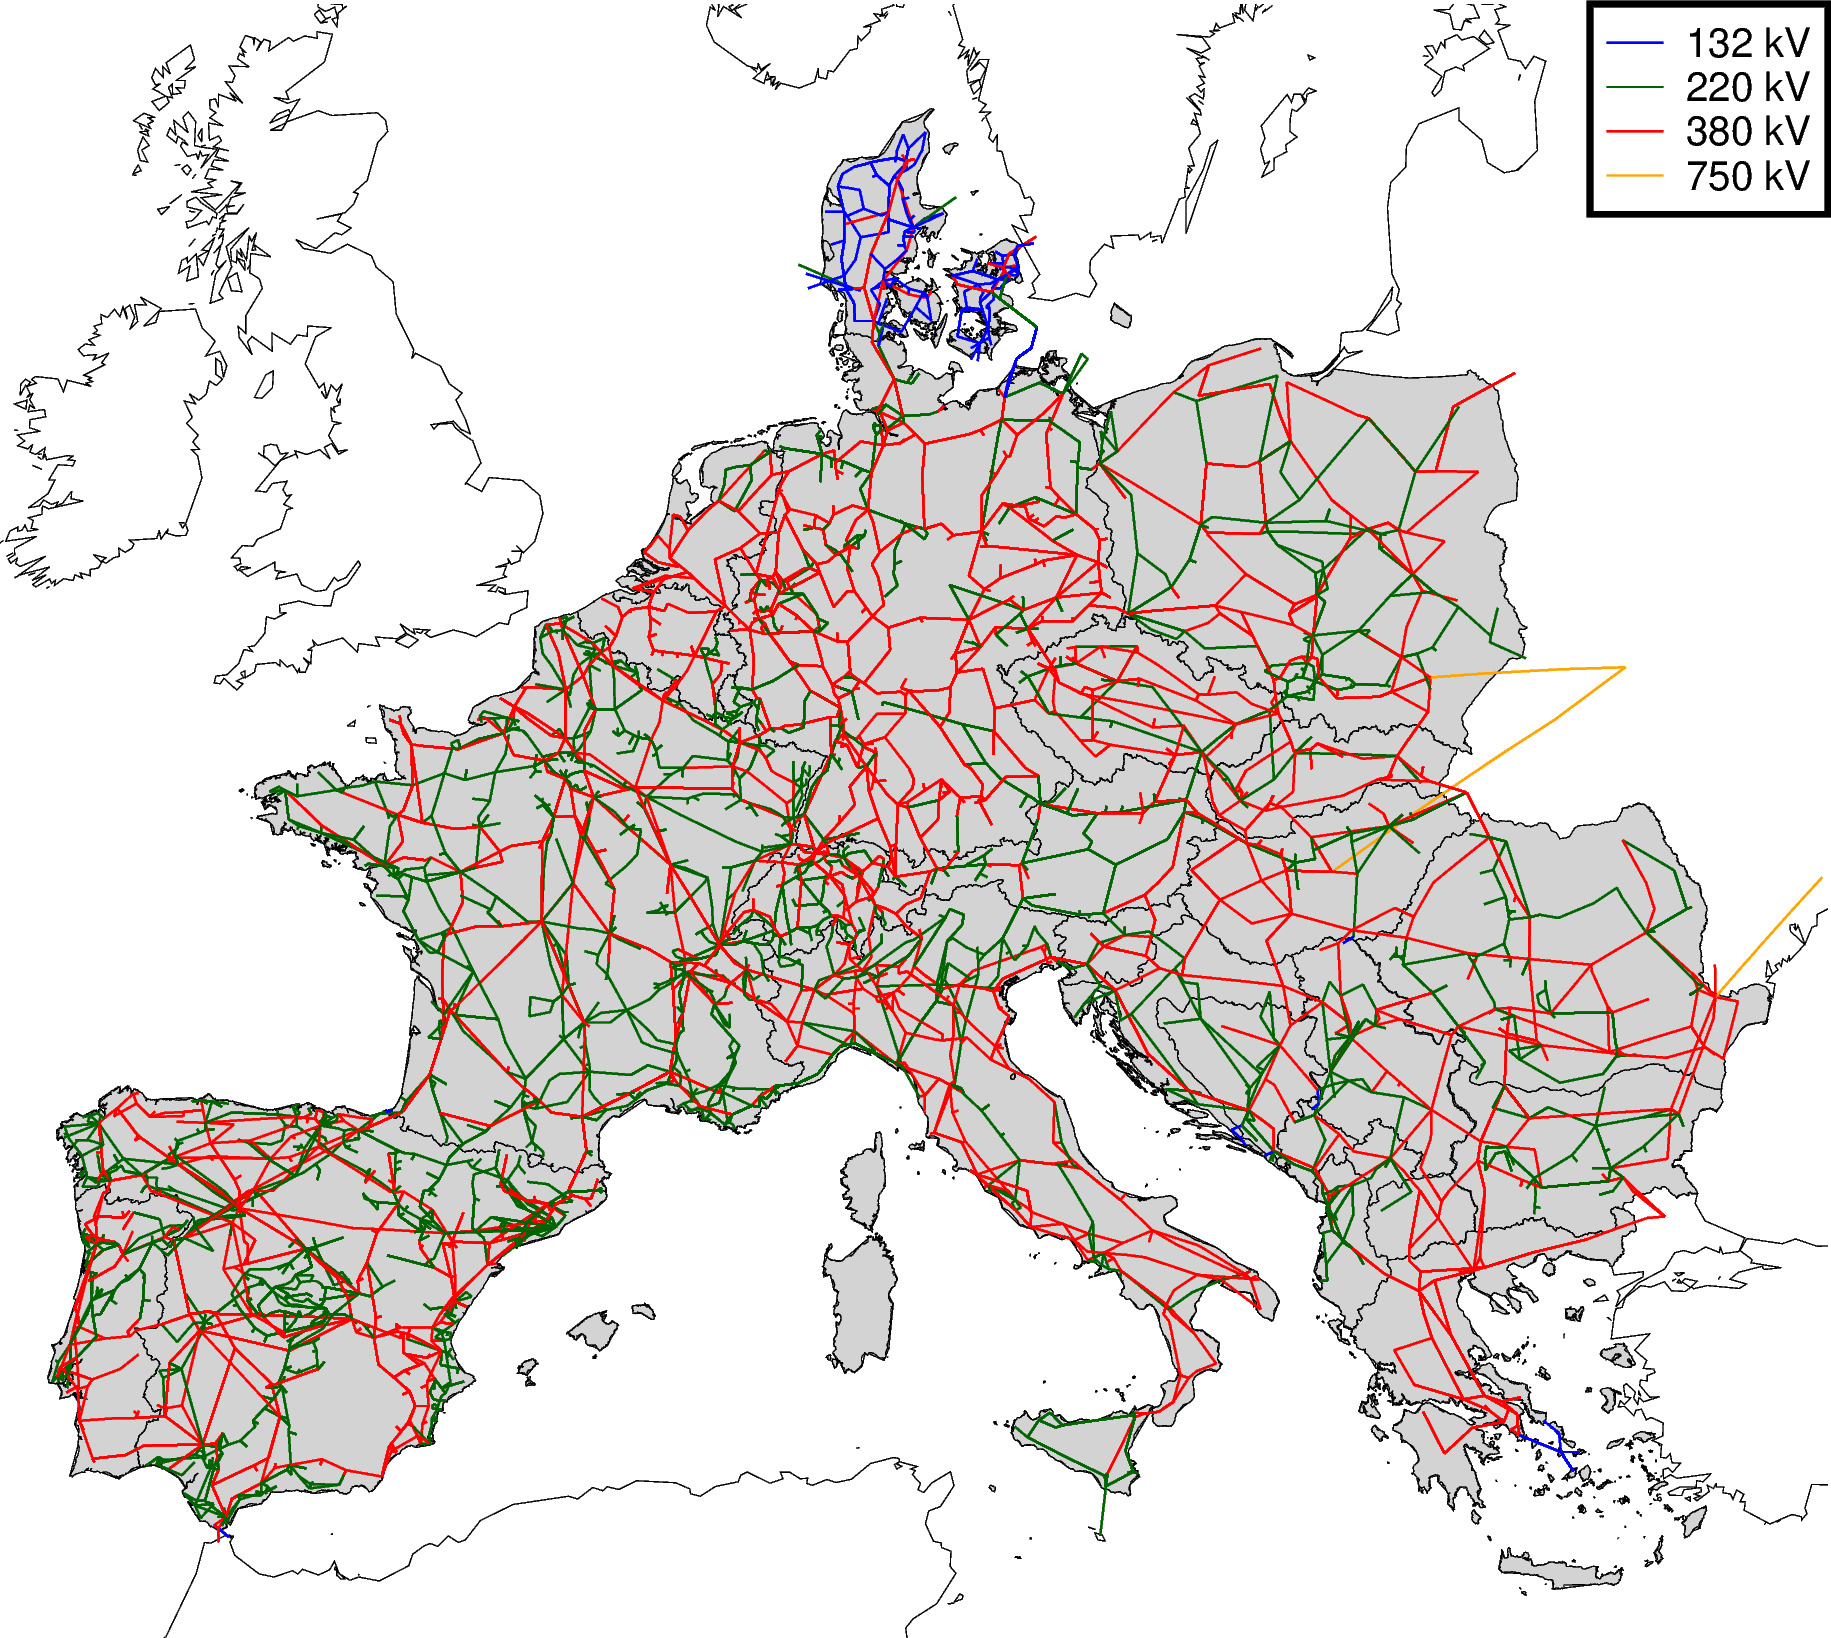

In [13]:
fig = pygmt.Figure()

fig.coast(region=region, projection='M16c', resolution='l',
          shorelines='1/0.2p,black', # coast only, no lakes
          dcw=['%s+p0.2p,black+glightgray' % country for country in countries]) # country borders

for line in lines:
    fig.plot(x = [line[0][0], line[1][0]], y = [line[0][1], line[1][1]], pen='0.5p,%s' % voltage_color[line[2]])

for v, color in voltage_color.items():
    fig.plot(x = [-30, -20], y = [0, 0], pen='0.5p,%s' % color, label='%d kV' % v)
fig.legend(position='jTR', box='+pblack+gwhite')

fig.show()

### Add generators

Also add a distinctive markers for all buses with a generator attached:

In [14]:
gen_buses = [(bus['coord'], bus['base_kv']) for bus in model['bus'].values() if bus['bus_type'] > 1]

gen_buses_by_voltage = {v: [] for v in voltage_levels}
for coord, v in gen_buses:
    gen_buses_by_voltage[v] += [coord]

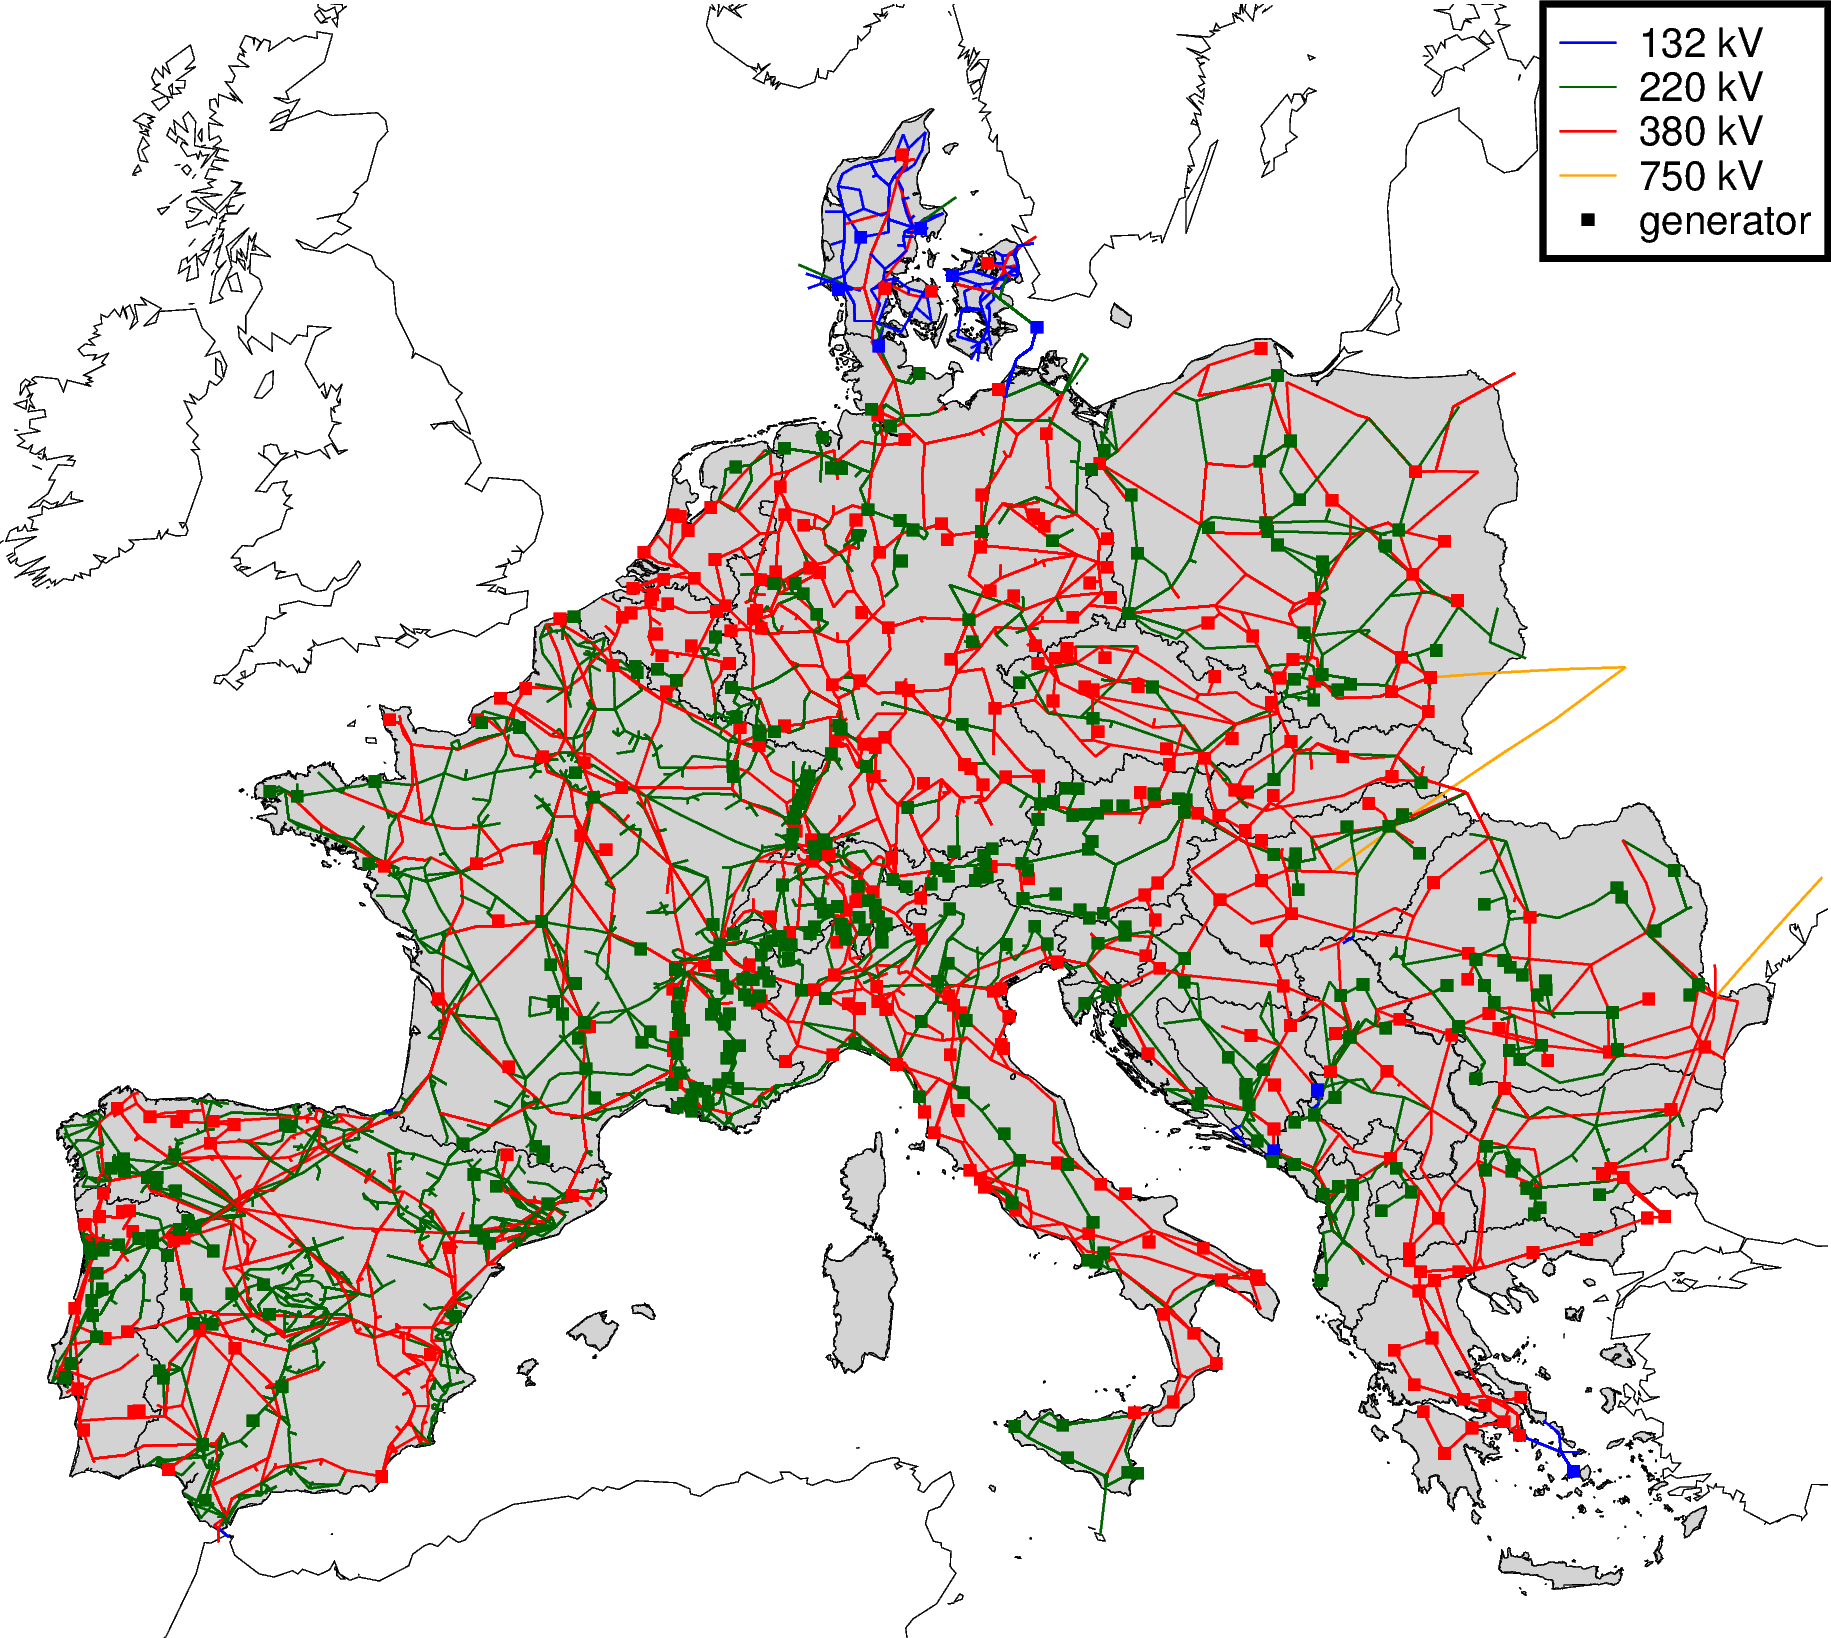

In [15]:
fig = pygmt.Figure()

fig.coast(region=region, projection='M16c', resolution='l',
          shorelines='1/0.2p,black', # coast only, no lakes
          dcw=['%s+p0.2p,black+glightgray' % country for country in countries]) # country borders

for line in lines:
    fig.plot(x = [line[0][0], line[1][0]], y = [line[0][1], line[1][1]], pen='0.5p,%s' % voltage_color[line[2]])

for v in voltage_levels:
    fig.plot(data = gen_buses_by_voltage[v], style='s0.15c', fill=voltage_color[v])

for v, color in voltage_color.items():
    fig.plot(x = [-30, -20], y = [0, 0], pen='0.5p,%s' % color, label='%d kV' % v)
fig.plot(data = [[-30, 0]], style='s0.15c', fill='black', label='generator')
fig.legend(position='jTR', box='+pblack+gwhite')

fig.savefig('../figures/europe.pdf')
fig.show()

## Map of Switzerland only

Zooming on a high-density region such as Switzerland gives a less busy representation of the network:

In [16]:
CH_region = [5.6, 10.9, 45.6, 48.0]

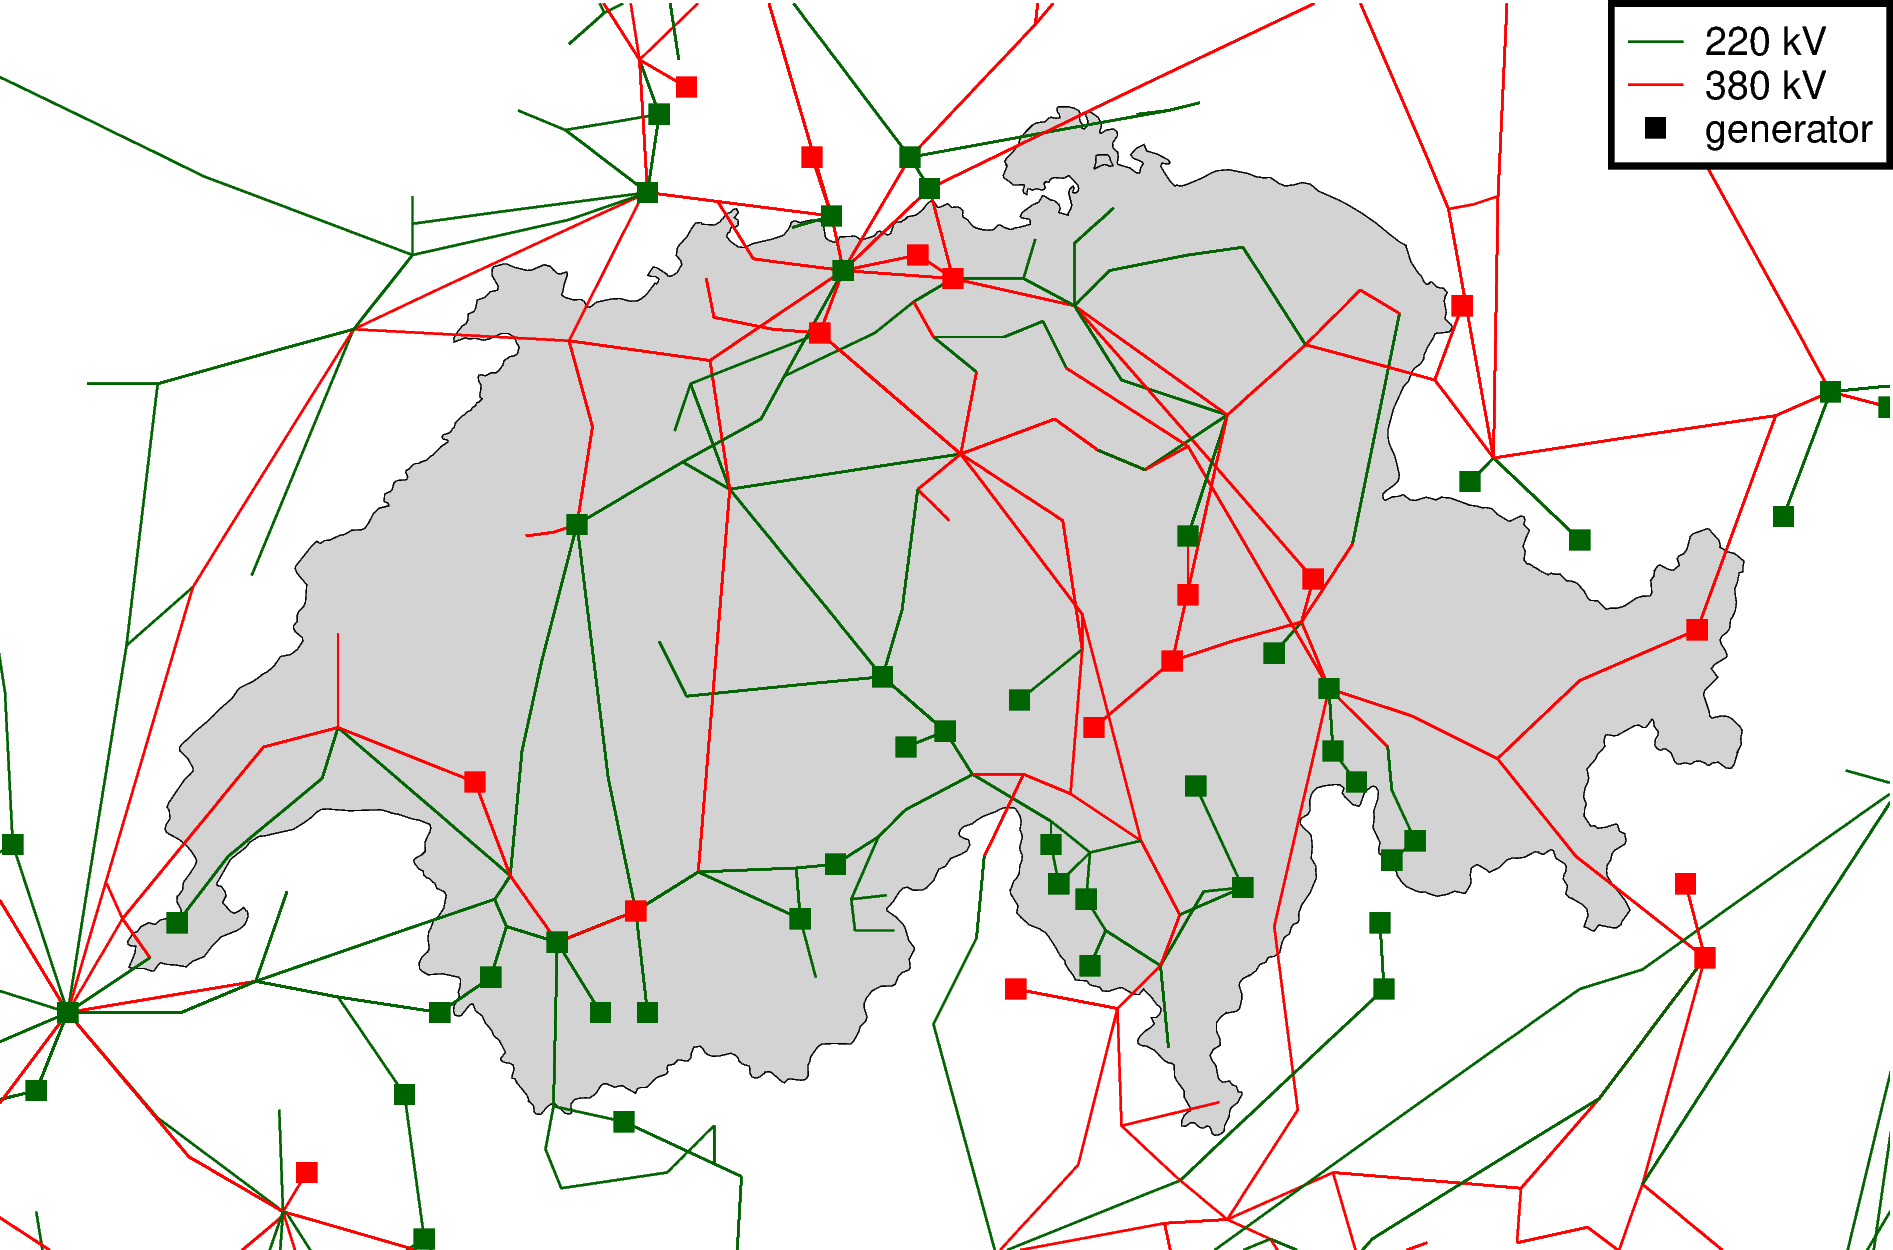

In [17]:
fig = pygmt.Figure()

fig.coast(region=CH_region, projection='M16c', resolution='i',
          dcw=['CH+p0.2p,black+glightgray']) # country borders

for line in lines:
    fig.plot(x = [line[0][0], line[1][0]], y = [line[0][1], line[1][1]], pen='0.5p,%s' % voltage_color[line[2]])

for v in voltage_levels:
    fig.plot(data = gen_buses_by_voltage[v], style='s0.25c', fill=voltage_color[v])

for v, color in voltage_color.items():
    if v in [220, 380]:
        fig.plot(x = [-30, -20], y = [0, 0], pen='0.5p,%s' % color, label='%d kV' % v)
fig.plot(data = [[-30, 0]], style='s0.25c', fill='black', label='generator')
fig.legend(position='jTR', box='+pblack+gwhite')

fig.savefig('../figures/switzerland.pdf')
fig.show()

## Map of Europe with Switzerland as inset

The detailed map of Switzerland can also be combined with the map of the entire network:

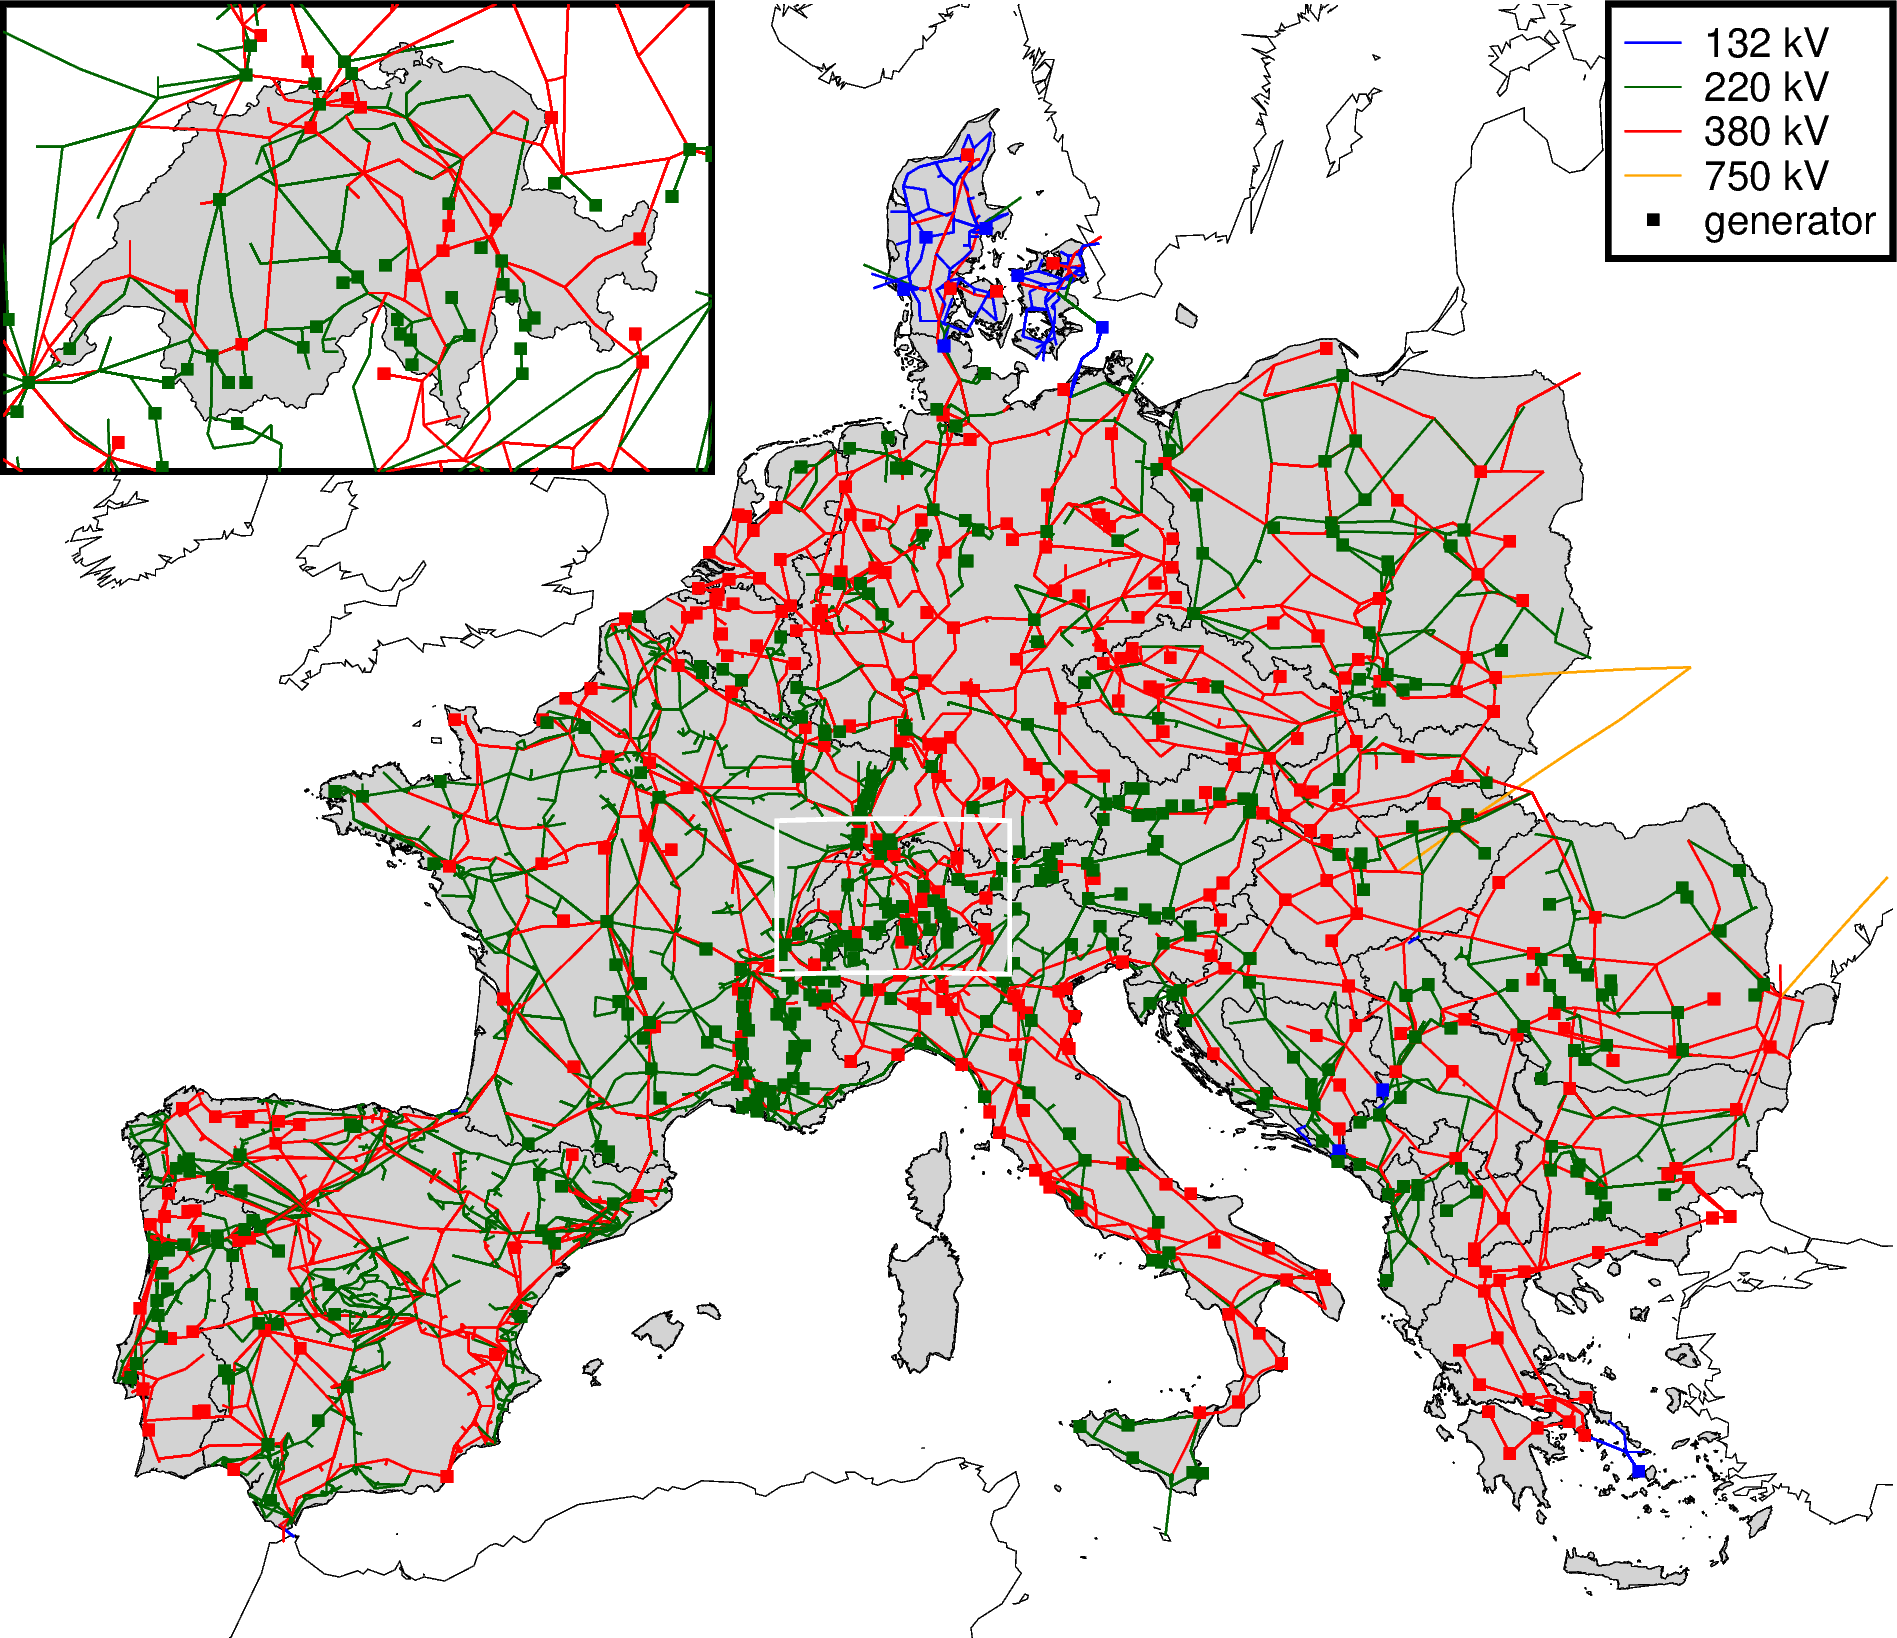

In [18]:
fig = pygmt.Figure()

fig.coast(region=region, projection='M16c', resolution='l',
          shorelines='1/0.2p,black', # coast only, no lakes
          dcw=['%s+p0.2p,black+glightgray' % country for country in countries]) # country borders

for line in lines:
    fig.plot(x = [line[0][0], line[1][0]], y = [line[0][1], line[1][1]], pen='0.5p,%s' % voltage_color[line[2]])

for v in voltage_levels:
    fig.plot(data = gen_buses_by_voltage[v], style='s0.15c', fill=voltage_color[v])

fig.plot(x = [CH_region[0], CH_region[1], CH_region[1], CH_region[0], CH_region[0]],
         y = [CH_region[2], CH_region[2], CH_region[3], CH_region[3], CH_region[2]],
         pen='1p,white')

with fig.inset(position='jTL', region=CH_region, projection='M6c',
               box='+pblack+gwhite'):
    
    fig.coast(dcw=['CH+p0.2p,black+glightgray'], resolution='i') 
    
    for line in lines:
        fig.plot(x = [line[0][0], line[1][0]], y = [line[0][1], line[1][1]], pen='0.5p,%s' % voltage_color[line[2]])
    
    for v in voltage_levels:
        fig.plot(data = gen_buses_by_voltage[v], style='s0.15c', fill=voltage_color[v])

for v, color in voltage_color.items():
    fig.plot(x = [-30, -20], y = [0, 0], pen='0.5p,%s' % color, label='%d kV' % v)
fig.plot(data = [[-30, 0]], style='s0.15c', fill='black', label='generator')
fig.legend(position='jTR', box='+pblack+gwhite')

fig.savefig('../figures/europe_with_inset.pdf')
fig.show()